In [1]:
import numpy as np
from scipy.fftpack import fft2, ifft2
from scipy.optimize import fsolve
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
# Constants
M = 0.1  # Mobility
kappa = 0.01  # Gradient coefficient
W = 0.1  # Bulk free-energy coefficient
L = 10.0  # Domain size
N = 128  # Number of grid points
dt = 0.1  # Time step
total_steps = 1000  # Total time steps

# Initialize variables
x = np.linspace(0, L, N, endpoint=False)
y = np.linspace(0, L, N, endpoint=False)
X, Y = np.meshgrid(x, y)
c0 = 0.5
c = c0 + 0.01*np.random.randn(N, N)  # Initial concentration with random noise

# Compute wave vectors
kx = np.fft.fftfreq(N, d=L/N) * 2.0 * np.pi
ky = np.fft.fftfreq(N, d=L/N) * 2.0 * np.pi
KX, KY = np.meshgrid(kx, ky)
K2 = KX**2 + KY**2

# Helper function to calculate the chemical potential
def chemical_potential(c, kappa, W):
    f_prime = 2 * W * (c*(1 - c)**2 + (c - 1)*c**2)
    mu = f_prime - kappa * (4.0 * np.pi**2 * K2 * fft2(c)).real
    return mu

# Time loop
for t in range(total_steps):
    # Fourier transform of concentration
    c_hat = fft2(c)

    # Use RK4 for the first three steps
    if t < 3:
        mu = chemical_potential(c, kappa, W)
        k1 = fft2(mu)
        k2 = fft2(chemical_potential(ifft2(c_hat + 0.5 * dt * k1).real, kappa, W))
        k3 = fft2(chemical_potential(ifft2(c_hat + 0.5 * dt * k2).real, kappa, W))
        k4 = fft2(chemical_potential(ifft2(c_hat + dt * k3).real, kappa, W))
        c_hat_new = c_hat + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
    # Use Adams-Moulton for subsequent steps
    else:
        # Implicit update of concentration in Fourier space
        mu = chemical_potential(c, kappa, W)
        c_hat_new = (c_hat - dt * M * K2 * fft2(mu)) / (1 + dt * kappa * M * K2**2)

    # Inverse Fourier transform to update concentration
    c = np.real(ifft2(c_hat_new))
    
    # Checkpoint: Print and/or save data at intervals
    if t % 100 == 0:
        print(f"Completed time step {t}")
        # Save data here if needed

print("Simulation complete!")


Completed time step 0
Completed time step 100


C:\Users\gongwent\AppData\Local\Temp\ipykernel_140140\3124427655.py:31: RuntimeWarning: overflow encountered in multiply
  f_prime = 2 * W * (c*(1 - c)**2 + (c - 1)*c**2)


Completed time step 200
Completed time step 300
Completed time step 400
Completed time step 500
Completed time step 600
Completed time step 700
Completed time step 800
Completed time step 900
Simulation complete!


TypeError: Invalid shape (128,) for image data

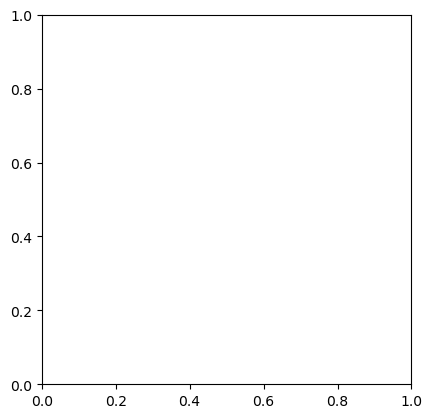

In [2]:
plt.imshow(c[-1],cmap='RdBu_r', vmin=0.0, vmax=1.0)
plt.title('$c_0=%.1f$'% c0)
plt.savefig('cahn-hilliard-c0-%.1f.png'% c0)
plt.show()

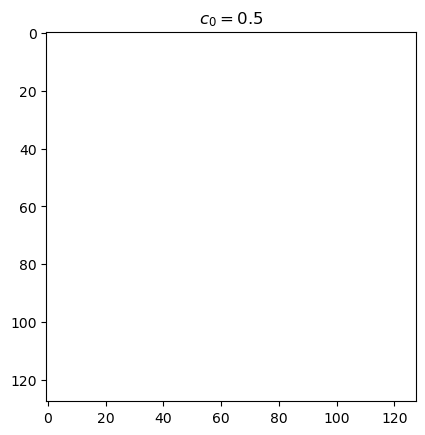

In [7]:
plt.imshow(c, cmap='RdBu_r', vmin=0.0, vmax=1.0)
plt.title(f'$c_0={c0:.1f}$')
plt.savefig(f'RK4_cahn-hilliard-c0-{c0:.1f}.png')
plt.show()

In [ ]:
import numpy as np
from numpy.fft import fft2, ifft2
from scipy.optimize import fsolve

# Parameters
Nx, Ny = 100, 100
dx, dy = 1.0, 1.0
dt = 0.01
M = 1.0
kappa = 0.02
Nt = 200

# Initialize
c = np.random.rand(Nx, Ny)  # Initial concentration field
c_hat = fft2(c)

# Generate wavenumbers kx, ky
kx = np.fft.fftfreq(Nx, d=dx) * 2 * np.pi
ky = np.fft.fftfreq(Ny, d=dy) * 2 * np.pi
K = np.array(np.meshgrid(kx, ky, indexing='ij'))
K2 = np.sum(K * K, axis=0)

# Dealiasing mask
kmax_dealias = kx.max() * 2.0 / 3.0
dealias = np.array((np.abs(K[0]) < kmax_dealias) * (np.abs(K[1]) < kmax_dealias))

def laplacian_fft(f_hat, K2):
    return -K2 * f_hat

# Assuming you have a function to calculate chemical potential mu = chemical_potential(c)
# def chemical_potential(c):  
#     return ...

# RK4 for the first three steps
for _ in range(3):
    mu = chemical_potential(ifft2(c_hat).real)
    k1 = M * laplacian_fft(fft2(mu), K2)
    mu = chemical_potential(ifft2(c_hat + 0.5 * dt * k1).real)
    k2 = M * laplacian_fft(fft2(mu), K2)
    mu = chemical_potential(ifft2(c_hat + 0.5 * dt * k2).real)
    k3 = M * laplacian_fft(fft2(mu), K2)
    mu = chemical_potential(ifft2(c_hat + dt * k3).real)
    k4 = M * laplacian_fft(fft2(mu), K2)

    c_hat += dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
    c_hat *= dealias

# Adams-Moulton for subsequent steps
c_n_minus_1 = c_hat  # Store previous step
for t in range(3, Nt):
    mu = chemical_potential(ifft2(c_hat).real)
    F_n = M * laplacian_fft(fft2(mu), K2)
    
    # Implicit Adams-Moulton Step
    # Assuming mu(c) is a nonlinear function of c, so we'll use fsolve to solve the implicit equation
    def func(new_c_hat):
        new_mu = chemical_potential(ifft2(new_c_hat).real)
        F_n_plus_1 = M * laplacian_fft(fft2(new_mu), K2)
        return new_c_hat - c_hat - 0.5 * dt * (F_n + F_n_plus_1)
    
    c_hat = fsolve(func, c_hat)
    c_hat *= dealias
    c_n_minus_1 = c_hat

# Transform back to real space to get final result
c_final = ifft2(c_hat).real
